# Adaboost 

**Boosting** é uma abordadem de Machine Learning baseada na ideia de criar regras de predição com alta acurácia pela combinação de regras fracas e imprecisas. Boosting também é uma das abordages de aprendizagem supervisionada mais populares e bem sucedidas.

O **Adaboost** é a técnica mais popular de boosting. A ideia básica do algoritmo é, para cada iteração, treinar um classificador fraco (accurácia > 50%) dando preferência (maiores pesos) aos exemplos incorretamente classificados pelo classificador anterior. Ao final, um classificador forte é construído pelo voto ponderado de cada um dos classificadores.

**Vantagens:**
- Fácil implementação
- Rápido
- Apenas um parâmetro para tunning (número de estimadores)
- Pode ser usado como seletor de características
- Boa generalização
- Versátil

**Desvantagens:**
- Não é robusto a presença de ruído uniforme
- Muitos classificadores fracos podem acarretar em overfitting


### Algoritmo básico do Adaboost
1. Para cada um dos n_estimadores:
    - treine um classificador binário $C_i$ com $y \in \{-1, +1\}$ de acordo com os pesos $w$
    - Calcula as predições do classificador
    - Calcule a taxa de erro ponderada $$e = w*(y \neq y_{pred})$$
    - Calcule os coeficientes $$\alpha_i = 0.5 * \log{\frac{1-e}{e}}$$
    - Atualize os pesos $$w = w*\exp^{-\alpha_i *y*y_pred} $$
    - Normalize os pesos $$w = \frac{w}{sum(w)}$$

O Classificador final será dado por:

$$sign(\sum_i{\alpha_i*C_i.predict(Xtest)})$$

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

%matplotlib inline

(0, 10)

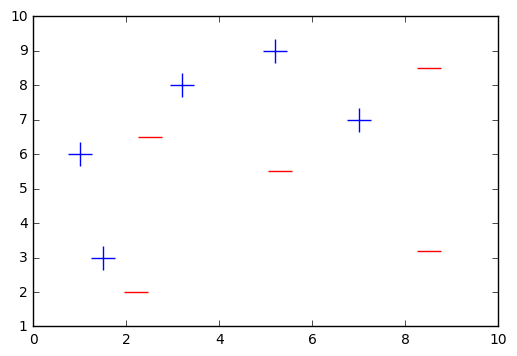

In [2]:
x = np.array([[1.0, 6.0],[1.5, 3.0],[3.2, 8.0],[5.2, 9.0],[7.0, 7.0],
              [2.2, 2.0],[2.5, 6.5],[5.3, 5.5],[8.5, 8.5],[8.5, 3.2]])
y = np.array([1, 1, 1, 1, 1, -1, -1, -1, -1, -1])

plt.scatter(x[:5,0], x[:5,1], s=300, marker='+')
plt.scatter(x[5:,0], x[5:,1], s=300, marker='_', color='red')
plt.xlim(0, 10)

In [3]:
def compute_weighted_accuracy(pred, y, weights):
    return sum([w for p,t,w in zip(pred, y, weights) if p==t])/sum(weights)

def sign(x):
    return 0 if x == 0 else 1 if x > 0 else -1

In [4]:
class LineClassifier():
    def __init__(self, weights=np.array([])):
        self.weights = weights
        self.value, self.col = 0, 0
    
    def fit(self, x, y):      
        column_count = len(x[0])
        
        if len(self.weights) == 0:
            self.weights = [1.0/len(x)]*len(x)
        
        best_accuracy = 0.0
        
        for col in range(column_count):
            column_values = [row[col] for row in x]
                
            for value in np.arange(min(column_values), max(column_values), 0.1):
                accuracy = compute_weighted_accuracy(LineClassifier.predict_(x, col, value), y, self.weights)
                
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    self.col, self.value = col, value
        
        print(self.col, self.value, best_accuracy)
                
    def predict(self, x):
        return LineClassifier.predict_(x, self.col, self.value)
    
    @staticmethod
    def predict_(x, col, value):
        if col == 0: 
            return [1 if row[col] < value else -1 for row in x]
        else:
            return [1 if row[col] > value else -1 for row in x]

In [10]:
class AdaBoost():
    def __init__(self, base_estimator=LineClassifier, minHitRate=0.5, n_estimators=50):
        self.classifiers = []
        self.alphas = []
        self.weights = []
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.minHitRate = minHitRate
    
    def fit(self, x, y):
        from math import log, e
        ln = lambda x: log(x)/log(e)
        
        if len(self.weights) == 0:
            self.weights = [1.0/len(x)]*len(x)
        
        for n in range(self.n_estimators):
            clf = self.base_estimator()
            clf.weights = self.weights
            clf.fit(x, y)
            
            pred = clf.predict(x)
            error = 1.0 - compute_weighted_accuracy(pred, y, self.weights)
            
            if(error < self.minHitRate):
                alpha = 0.5 * ln((1-error)/error)
                
                self.weights = [w*(e**(-alpha*p*t)) for p,t,w in zip(pred, y, self.weights)]
                self.weights = [w/sum(self.weights) for w in self.weights]
                
                self.classifiers.append(clf)
                self.alphas.append(alpha)
                
                print(error, alpha, self.weights, sep='\n', end='\n\n')
    
    def predict(self, x):
        predictions = []

        for row in x:
            weak_sum = 0.0
            
            for alpha, clf in zip(self.alphas, self.classifiers):
                weak_sum += alpha*clf.predict([row])[0] 
            predictions.append(sign(weak_sum))
        
        return predictions

In [14]:
ada = AdaBoost(base_estimator=LineClassifier, n_estimators=3, minHitRate=0.3)
ada.fit(x, y)
ada.predict(x)

0 1.5 0.7000000000000001
0.29999999999999993
0.42364893019360195
[0.071428571428571397, 0.071428571428571397, 0.16666666666666663, 0.16666666666666663, 0.16666666666666663, 0.071428571428571397, 0.071428571428571397, 0.071428571428571397, 0.071428571428571397, 0.071428571428571397]

0 7.0 0.785714285714
0.214285714286
0.6496414920651304
[0.045454545454545442, 0.045454545454545442, 0.10606060606060606, 0.10606060606060606, 0.10606060606060606, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.045454545454545442, 0.045454545454545442]

1 6.5 0.863636363636
0.136363636364
0.9229133452491655
[0.16666666666666669, 0.16666666666666669, 0.061403508771929842, 0.061403508771929842, 0.061403508771929842, 0.096491228070175461, 0.096491228070175461, 0.096491228070175461, 0.16666666666666669, 0.026315789473684209]



[1, 1, 1, 1, 1, -1, -1, -1, -1, -1]

(0, 10)

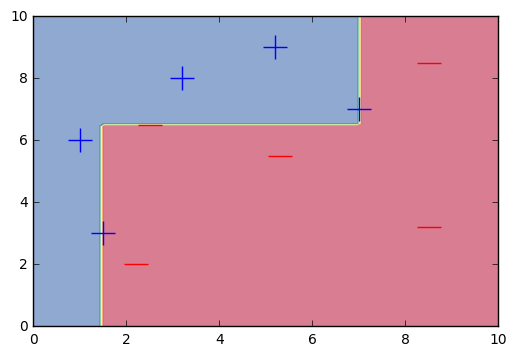

In [15]:
xv, yv = np.meshgrid(np.linspace(0, 10, 100), np.linspace(0, 10, 100))
xyv = np.concatenate((xv, yv), axis=1)

pred_2 = []
for i in range(xv.shape[0]):
    for j in range(xv.shape[1]):
        pred_2.append(ada.predict([[xv[i,j], yv[i,j]]]))

pred_2 = np.array(pred_2).reshape(xv.shape)
plt.contourf(xv, yv, pred_2, cmap=plt.cm.Spectral, alpha=0.6)
plt.scatter(x[:5,0], x[:5,1], s=300, marker='+')
plt.scatter(x[5:,0], x[5:,1], s=300, marker='_', color='red')
plt.xlim(0,10)
plt.ylim(0,10)